# Technical Subreddit Post Sorter Application


## Project Goals: 
    
###  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   *Internet subforums tend to have a  lot of traffic consisting of posts that would have been better posted somewhere else. Sometimes users don’t know where their post best belongs among these similar technical subforums because of their similar nature.  I took on this project with the goal of creating an application that could sort reddit posts to their ideal subreddits, when those subreddits are similar in terms of technical content. Specifically, I used the subreddits r/Python, r/compsci, r/datascience, and r/learnmachinelearning. I wanted to attempt this both because it would be a useful application and because it would be challenge. It would be a challenge because the similarity of those subreddits would make classification difficult, and the technical nature of those subreddits would mean they have a distinct vocabulary of words likely not trained within traditional embeddings like glove. The application would be useful to both users and to subreddit moderators. It could flag to subreddit moderators that a new post doesn’t belong and is taking up traffic/page space and is off topic, without the moderators having to read so many posts. Or it could suggest to a user before actually posting where their post may be better suited to, or somewhere they may like to cross post too.  Custom word2vec embeddings and feature creation techniques (discovering frequent bigram/trigram/quadgram vector meanings before telling the model how many and what size of filter to use, rather than plugging in numbers and hoping for the best) were employed to solve the problem using a Convolutional neural  network. The application using this model was deployed to Heroku.*



    
    
## Data web scraping:
* Data was scraped at the beginning of January using praw, a reddit API scraper package. Posts from these four subreddits: (Python, datascience, learnmachinelearning, compsci) were collected over every available timeframe that reddit allows users to sort by, and by top and by controversial posts, then duplicates were removed. Posts with URLs and other characters (see scraper file) were coded not to be scraped. 100 posts from each subreddit for each timeframe and category were collected. Posts with over 200 characters were not scraped.

## Cleaning:
* Data was cleaned using spacy stopwords and tokenized using nltk word_tokenize. Common in consequential words (stopwords) were removed from sentences, and the remaining words were left as comma separated tokens.

## Feature Creation:

#### Custom word2vec embedding:
* Since these subreddits contain a vocabulary of technical nature, pretrained embeddings may not have been trained on many of the unique words found in vocab of these subreddits and may not help with text classification . I trained a custom Word2Vec embedding with reddit titles contained within the train data only.

#### "Finding" the filters:
* First I identified all frequently occurring unigrams/bigrams/trigrams within the data. Then I converted them into tensors according to the custom word2vec embedding. Once the tensor representations were obtained (the "meaning" of the grams), I found which of those tensors had a high frequency of significant cosine similarity among all other grams of the same size in the data. By identifying the number of frequently occurring gram "meanings" within the dataset, I was able to determine the optimal number of convolutional filters for the model to use.




## Model:
* A convolutional neural network with filters of size (1,2,3,4) words. Embedding dimensions were experimented with to obtain optimal results . A Single fully connected layer also gave the best results, as well as a learning rate = .001, Batch size = 5, and dropout = 0.3.

## Training:
* I evaluated the loss/accuracy of a validation set against the train set and trained past the plateau of model accuracy to obtain a model with that has the highest accuracy while still having a lower validation loss than train loss to avoid overfitting, and carry performance to the real world. I used enough epochs so that the plateau of validation loss/accuracy is clearly visible on the plots of loss/accuracy vs training epoch.


## Issues with data:
* We only have about a thousand data points to train with, This is certainly not ideal for a nueral network. Also, posts that include links without a lot of context will be difficult for this model to classify.

## Results:
* Model accuracy using custom word2vec :62%
* Model accuracy using glove : 53%



## Deployment:
* Application was created using flask and Heroku. It takes about 30 seconds to load, please be patient. The app can be found here: https://datascience-reddit-post-sorter.herokuapp.com . Please see the app.py file in the repo for the application code. 

## Instructions to run:
* Again, the app url can be found here: https://datascience-reddit-post-sorter.herokuapp.com . It takes about 30 seconds to load, please be patient.  Type the title of the reddit post you wish to make and it will suggest where it belongs among those four subreddits. All csv files and saved model outputs are included in the repo. If you wish to run this project, then after downloading simply link to the necessary paths within the project to where you keep those files. Cells should be run in order of course.


## Discussion:
* The custom embeddings made a clear difference in classification performance. Also, after playing with the number of filters in the model and viewing the resulting performance, it seems the original number of filters identified during feature creation did in fact optimize the model! With an accuracy of 62%, vs an accuracy of 25%  by guessing at random what subreddit a post should belong in, this model deployed as the application would in fact be helpful in automatically flagging posts that don’t belong and take up subreddit space (for frustrated reddit moderators), or for quickly suggesting to users where their post may be better suited or where it should be cross-posted to. Since there are only four subreddits trained here, the app is sort of a proof-of-concept. This application could be easily expanded to using multiple subreddits of similar or technical nature where the user may not be certain where best to make their reddit post.

### Let's Begin!

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import torchtext
from torchtext import data
from torchtext import datasets
import glove
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gensim
from gensim.models import Word2Vec
import spacy
nlp = spacy.load("en_core_web_sm")
all_stopwords = nlp.Defaults.stop_words
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
import matplotlib.pyplot as plt
from wordcloud import WordCloud
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Importing webscraped reddit posts from the four subreddits

In [2]:


comsdata = pd.read_csv(r'C:\Users\Dave\Desktop\datadata\Practice\csgooo\reddit_proj\title stuff\titles_train.csv', usecols=['text', 'label'])
print(comsdata['text'])


0       New method to reduce characters in binary codi...
1       From 53% to 95% acc - Real vs Fake Faces Class...
2       Is there a University that proposes a master d...
3       GitHub Copilot Generated Insecure Code In 40% ...
4                                     Loading Keras Model
                              ...                        
1310                          This sub is fucking garbage
1311    Convolution is not dead. (A ConvNet for the 20...
1312        EliteMini HX90 for data science. Any thought?
1313                  Course that helps build a portfolio
1314    What exactly does a Computer Scientist (with a...
Name: text, Length: 1315, dtype: object


### Tokenizing and removing stopwords from the posts

In [3]:
train_data = comsdata.copy() 
#print(train_data)
train_data['text'] = comsdata['text'].str.lower().apply(word_tokenize)
# print(train_data)


coms = train_data['text']
coms = coms.apply(lambda x: [item for item in x if item not in stopwords])
sentences = coms
print(sentences)


        


0       [new, method, reduce, characters, binary, codi...
1       [53, %, 95, %, acc, -, real, vs, fake, faces, ...
2       [university, proposes, master, degree, linking...
3       [github, copilot, generated, insecure, code, 4...
4                                 [loading, keras, model]
                              ...                        
1310                              [sub, fucking, garbage]
1311         [convolution, dead, ., (, convnet, 2020s, )]
1312      [elitemini, hx90, data, science, ., thought, ?]
1313                    [course, helps, build, portfolio]
1314    [exactly, computer, scientist, (, phd, masters...
Name: text, Length: 1315, dtype: object


### Listing the number of unique uni/bi/tri/quad grams from all subreddits together, and each individual subreddit, using CountVectorizer.  We also create a wordcloud for each case.

785 number of unigrams with high frequency
395 number of bigram with high frequency
94 number of trigrams with high frequency
23 number of quadgrams with high frequency


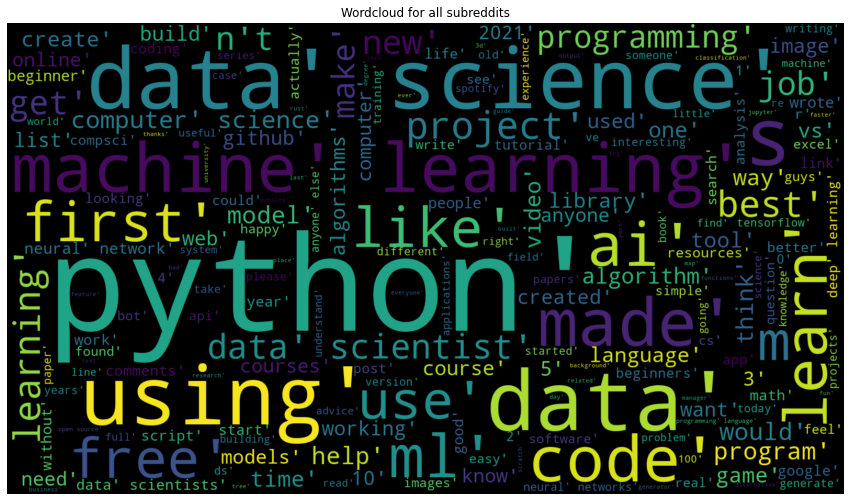

In [4]:
sentences_all = coms.astype(str)

#####################################################################################################################
# jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase = False, tokenizer=None)
X_all = vectorizer.fit_transform(sentences_all) #CountVectorizer lists the occurence of the grams but not the frequency.  
#print(vectorizer.get_feature_names())
X_all = X_all.toarray()
X_all = pd.DataFrame(X_all)
X_all.columns = vectorizer.get_feature_names()

X_all = X_all.sum(axis=0) #sum the results of countvectorizer to obtain the frequency
X_all = X_all.sort_values()
X_all = X_all[X_all >=3] #only interested in grams that occur at least 3 times in our dataset (for use in feature 
#creation of filters later)
#print(X_all)
print(len(X_all), "number of unigrams with high frequency")
X_all2 = np.repeat(X_all.index, X_all) #need to display each gram true to their frequency (for use in feature 
#creation of filters later).
X_all2 = pd.DataFrame(X_all2)
#print(len(X_all2))


vectorizer2 = CountVectorizer(ngram_range=(2, 2), lowercase = False, tokenizer=None) #bigrams
X2_all = vectorizer2.fit_transform(sentences_all)
#print(vectorizer.get_feature_names())
X2_all = X2_all.toarray()
X2_all = pd.DataFrame(X2_all)
X2_all.columns = vectorizer2.get_feature_names()


X2_all = X2_all.sum(axis=0)
X2_all = X2_all.sort_values()
X2_all = X2_all[X2_all >=2]
#print(X2_all)
print(len(X2_all), "number of bigram with high frequency")
X2_all2 = np.repeat(X2_all.index, X2_all)
X2_all2 = pd.DataFrame(X2_all2)
#print(len(X2_all2))

vectorizer3 = CountVectorizer(ngram_range=(3, 3), lowercase = False, tokenizer=None) #trigrams
X3_all = vectorizer3.fit_transform(sentences_all)
#print(vectorizer.get_feature_names())
X3_all= X3_all.toarray()
X3_all = pd.DataFrame(X3_all)
X3_all.columns = vectorizer3.get_feature_names()


X3_all = X3_all.sum(axis=0)
X3_all = X3_all.sort_values()
X3_all = X3_all[X3_all >=2]
print(len(X3_all), "number of trigrams with high frequency")
#print(X3_all)
X3_all2 = np.repeat(X3_all.index, X3_all)
X3_all2 = pd.DataFrame(X3_all2)
#print(len(X3_all2))


vectorizer4 = CountVectorizer(ngram_range=(4, 4), lowercase = False, tokenizer=None) #quadgrams
X4_all = vectorizer4.fit_transform(sentences_all)
#print(vectorizer.get_feature_names())
X4_all= X4_all.toarray()
X4_all = pd.DataFrame(X4_all)
X4_all.columns = vectorizer4.get_feature_names()


X4_all = X4_all.sum(axis=0)
X4_all = X4_all.sort_values()
X4_all = X4_all[X4_all >=2]
print(len(X4_all), "number of quadgrams with high frequency")
#print(X4_all)
X4_all2 = np.repeat(X4_all.index, X4_all)
X4_all2 = pd.DataFrame(X4_all2)
#print(len(X4_all2))

#####################################################################################################################




sentences_all = sentences_all.str.cat() #Concatenate strings for use in wordcloud
wordcloud = WordCloud(width=1600, height=900).generate(sentences_all)

# Display the generated image:
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud for all subreddits")
plt.show()



### Unique grams and wordcloud for subreddit: r/Python

9                     ['python', 'bytecode', 'explained']
12      ['make', 'lisp', '15x', 'faster', 'python', '4...
14      ['made', 'finance', 'database', '180.000', 'ti...
15      ['biggest', 'struggle', 'helping', 'newcomers'...
16      ['web', 'api', 'benchmarking', ':', 'python', ...
                              ...                        
1300    ['javascript', 'vs', 'python', 'web', 'develop...
1304    ['build', 'low-code', 'business', 'application...
1305    ['twitter', 'opening', 'full', 'tweet', 'archi...
1306    ['python', 'documentation', 'bad', ',', 'feel'...
1307    ['``', 'best', 'programming', 'language', 'lea...
Name: text, Length: 444, dtype: object
133 number of unigrams with high frequency
13 number of bigrams with high frequency
0 number of trigrams with high frequency
0 number of quadgrams with high frequency


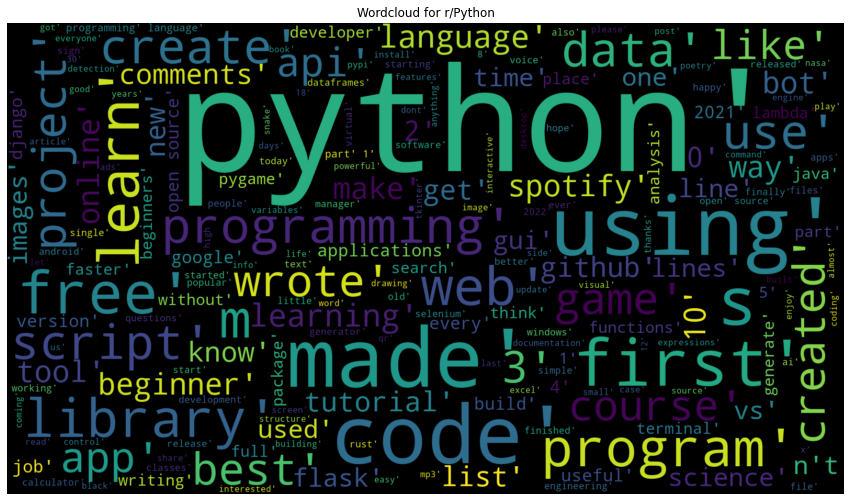

In [5]:
train_data_py = comsdata.copy().loc[comsdata['label'] == 'Python']
# print(train_data_py)

train_data_py['text'] = train_data_py['text'].str.lower().apply(word_tokenize)
# print(train_data_py)
coms_py = train_data_py['text']
coms_py = coms_py.apply(lambda x: [item for item in x if item not in stopwords])
sentences_py = coms_py.astype(str)
print(sentences_py)
# print(sentences)
#####################################################################################################################

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase = False, tokenizer=None)
X = vectorizer.fit_transform(sentences_py)
#print(vectorizer.get_feature_names())
X = X.toarray()
X = pd.DataFrame(X)
X.columns = vectorizer.get_feature_names()


X = X.sum(axis=0)
X = X.sort_values()
X = X[X >=4]
print(len(X), "number of unigrams with high frequency")




vectorizer2 = CountVectorizer(ngram_range=(2, 2), lowercase = False, tokenizer=None)
X2 = vectorizer2.fit_transform(sentences_py)
#print(vectorizer.get_feature_names())
X2 = X2.toarray()
X2 = pd.DataFrame(X2)
X2.columns = vectorizer2.get_feature_names()


X2 = X2.sum(axis=0)
X2 = X2.sort_values()
X2 = X2[X2 >=4]
print(len(X2), "number of bigrams with high frequency")


vectorizer3 = CountVectorizer(ngram_range=(3, 3), lowercase = False, tokenizer=None)
X3 = vectorizer3.fit_transform(sentences_py)
#print(vectorizer.get_feature_names())
X3= X3.toarray()
X3 = pd.DataFrame(X3)
X3.columns = vectorizer3.get_feature_names()

X3 = X3.sum(axis=0)
X3 = X3.sort_values()
X3 = X3[X3 >=4]
print(len(X3), "number of trigrams with high frequency")


vectorizer4 = CountVectorizer(ngram_range=(4, 4), lowercase = False, tokenizer=None)
X4 = vectorizer4.fit_transform(sentences_py)
#print(vectorizer.get_feature_names())
X4= X4.toarray()
X4 = pd.DataFrame(X4)
X4.columns = vectorizer4.get_feature_names()

X4 = X4.sum(axis=0)
X4 = X4.sort_values()
X4 = X4[X4 >=4]
print(len(X4), "number of quadgrams with high frequency")

#####################################################################################################################


sentences_py = sentences_py.str.cat()
wordcloud = WordCloud(width=1600, height=900).generate(sentences_py)

# Display the generated image:
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud for r/Python")
plt.show()





### Unique grams and wordcloud for subreddit: r/datascience

5                              ['standing', 'desks', '?']
6       ['difficult', 'stay', 'shape', 'professional',...
8            ["n't", 'understand', 'ds', 'code', 'tests']
11                                    ['selling', 'data']
21      ['data', 'science', '90', '%', 'boring', '10',...
                              ...                        
1301    ['’', 'best', 'platform', 'create', 'portfolio...
1302    ['prepare', 'manage/lead', 'teams', '?', 'litt...
1308                             ['get', 'meta/facebook']
1310                        ['sub', 'fucking', 'garbage']
1312    ['elitemini', 'hx90', 'data', 'science', '.', ...
Name: text, Length: 285, dtype: object
71 number of unigrams with high frequency
8 number of bigrams with high frequency
2 number of trigrams with high frequency
0 number of quadgrams with high frequency


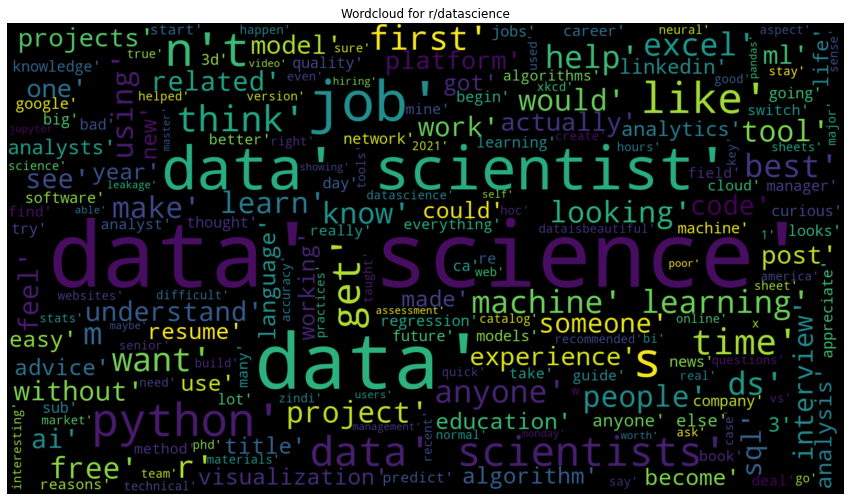

In [6]:
train_data_ds = comsdata.copy().loc[comsdata['label'] == 'datascience']
train_data_ds['text'] = train_data_ds['text'].str.lower().apply(word_tokenize)
# print(train_data_ds)
coms_ds = train_data_ds['text']
coms_ds = coms_ds.apply(lambda x: [item for item in x if item not in stopwords])
sentences_ds = coms_ds.astype(str)
print(sentences_ds)
# print(sentences)

#####################################################################################################################

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase = False, tokenizer=None)
X = vectorizer.fit_transform(sentences_ds)
#print(vectorizer.get_feature_names())
X = X.toarray()
X = pd.DataFrame(X)
X.columns = vectorizer.get_feature_names()

X = X.sum(axis=0)
X = X.sort_values()
X = X[X >=4]
print(len(X), "number of unigrams with high frequency")




vectorizer2 = CountVectorizer(ngram_range=(2, 2), lowercase = False, tokenizer=None)
X2 = vectorizer2.fit_transform(sentences_ds)
#print(vectorizer.get_feature_names())
X2 = X2.toarray()
X2 = pd.DataFrame(X2)
X2.columns = vectorizer2.get_feature_names()

X2 = X2.sum(axis=0)
X2 = X2.sort_values()
X2 = X2[X2 >=4]
print(len(X2), "number of bigrams with high frequency")


vectorizer3 = CountVectorizer(ngram_range=(3, 3), lowercase = False, tokenizer=None)
X3 = vectorizer3.fit_transform(sentences_ds)
#print(vectorizer.get_feature_names())
X3= X3.toarray()
X3 = pd.DataFrame(X3)
X3.columns = vectorizer3.get_feature_names()

X3 = X3.sum(axis=0)
X3 = X3.sort_values()
X3 = X3[X3 >=4]
print(len(X3), "number of trigrams with high frequency")


vectorizer4 = CountVectorizer(ngram_range=(4, 4), lowercase = False, tokenizer=None)
X4 = vectorizer4.fit_transform(sentences_ds)
#print(vectorizer.get_feature_names())
X4= X4.toarray()
X4 = pd.DataFrame(X4)
X4.columns = vectorizer4.get_feature_names()

X4 = X4.sum(axis=0)
X4 = X4.sort_values()
X4 = X4[X4 >=4]
print(len(X4), "number of quadgrams with high frequency")
#####################################################################################################################

sentences_ds = sentences_ds.str.cat()
wordcloud = WordCloud(width=1600, height=900).generate(sentences_ds)

# Display the generated image:
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud for r/datascience")
plt.show()



### Unique grams and wordcloud for subreddit: r/compsci

0       ['new', 'method', 'reduce', 'characters', 'bin...
2       ['university', 'proposes', 'master', 'degree',...
3       ['github', 'copilot', 'generated', 'insecure',...
7       ['american', 'computer', 'science', 'graduates...
25      ['personal', 'computers', 'like', '50-100', 'y...
                              ...                        
1267    ['cambridge', 'quantum', 'develops', 'algorith...
1279    ['blame', 'computer/', 'pein/', 'baffler', '.'...
1299    ['degree', 'would', 'augmented', 'reality', 'c...
1303    ['demonstration', 'reverse', 'image', 'search'...
1314    ['exactly', 'computer', 'scientist', '(', 'phd...
Name: text, Length: 251, dtype: object
72 number of unigrams with high frequency
4 number of bigrams with high frequency
0 number of trigrams with high frequency
0 number of quadgrams with high frequency


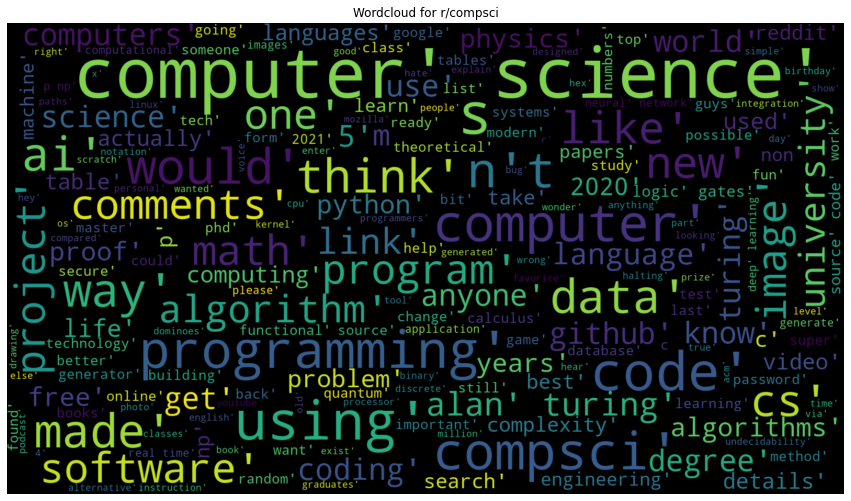

In [7]:
train_data_cs = comsdata.copy().loc[comsdata['label'] == 'compsci']
train_data_cs['text'] = train_data_cs['text'].str.lower().apply(word_tokenize)
# print(train_data_cs)
coms_cs = train_data_cs['text']
coms_cs = coms_cs.apply(lambda x: [item for item in x if item not in stopwords])
sentences_cs = coms_cs.astype(str)
print(sentences_cs)
# print(sentences)

#####################################################################################################################
# jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase = False, tokenizer=None)
X = vectorizer.fit_transform(sentences_cs)
#print(vectorizer.get_feature_names())
X = X.toarray()
X = pd.DataFrame(X)
X.columns = vectorizer.get_feature_names()

X = X.sum(axis=0)
X = X.sort_values()
X = X[X >=4]
print(len(X), "number of unigrams with high frequency")




vectorizer2 = CountVectorizer(ngram_range=(2, 2), lowercase = False, tokenizer=None)
X2 = vectorizer2.fit_transform(sentences_cs)
#print(vectorizer.get_feature_names())
X2 = X2.toarray()
X2 = pd.DataFrame(X2)
X2.columns = vectorizer2.get_feature_names()

X2 = X2.sum(axis=0)
X2 = X2.sort_values()
X2 = X2[X2 >=4]
print(len(X2), "number of bigrams with high frequency")

vectorizer3 = CountVectorizer(ngram_range=(3, 3), lowercase = False, tokenizer=None)
X3 = vectorizer3.fit_transform(sentences_cs)
#print(vectorizer.get_feature_names())
X3= X3.toarray()
X3 = pd.DataFrame(X3)
X3.columns = vectorizer3.get_feature_names()

X3 = X3.sum(axis=0)
X3 = X3.sort_values()
X3 = X3[X3 >=4]
print(len(X3), "number of trigrams with high frequency")


vectorizer4 = CountVectorizer(ngram_range=(4, 4), lowercase = False, tokenizer=None)
X4 = vectorizer4.fit_transform(sentences_cs)
#print(vectorizer.get_feature_names())
X4= X4.toarray()
X4 = pd.DataFrame(X4)
X4.columns = vectorizer4.get_feature_names()

X4 = X4.sum(axis=0)
X4 = X4.sort_values()
X4 = X4[X4 >=4]
print(len(X4), "number of quadgrams with high frequency")

#####################################################################################################################

sentences_cs = sentences_cs.str.cat()
wordcloud = WordCloud(width=1600, height=900).generate(sentences_cs)

# Display the generated image:
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud for r/compsci")
plt.show()


### Unique grams and wordcloud for subreddit: r/learnmachinelearning

1       ['53', '%', '95', '%', 'acc', '-', 'real', 'vs...
4                           ['loading', 'keras', 'model']
10      ['want', 'move', 'onto', 'python', 'feel', "'m...
13               ['backpropagation', 'scratch', 'python']
17      ['using', 'drones', 'detect', 'potential', 'co...
                              ...                        
1297    ['computer', 'science', 'vs', 'machine', 'lear...
1298                         ['multiplications', 'japan']
1309     ['racing', 'game', 'ai', '(', 'trackmania', ')']
1311    ['convolution', 'dead', '.', '(', 'convnet', '...
1313            ['course', 'helps', 'build', 'portfolio']
Name: text, Length: 335, dtype: object
113 number of unigrams with high frequency
16 number of bigrams with high frequency
2 number of trigrams with high frequency
0 number of quadgrams with high frequency


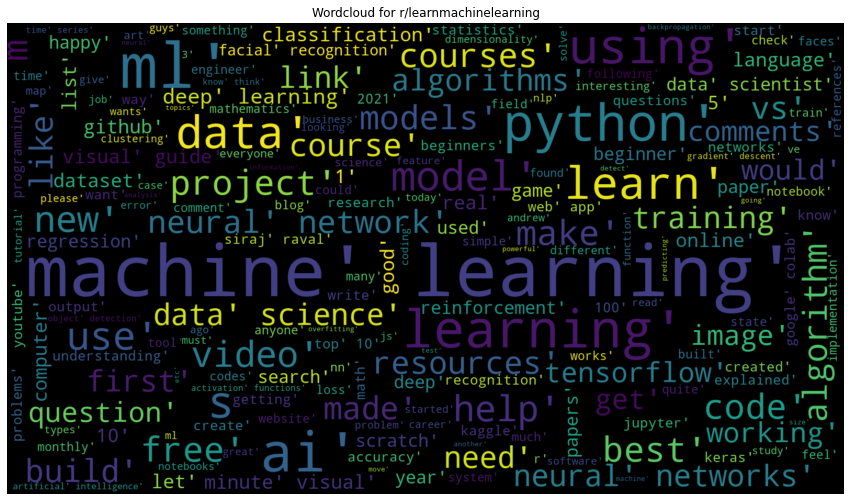

In [8]:
train_data_lml = comsdata.copy().loc[comsdata['label'] == 'learnmachinelearning']
train_data_lml['text'] = train_data_lml['text'].str.lower().apply(word_tokenize)
#print(train_data_lml)
coms_lml = train_data_lml['text']
coms_lml = coms_lml.apply(lambda x: [item for item in x if item not in stopwords])
sentences_lml = coms_lml.astype(str)
print(sentences_lml)
# print(sentences)

#####################################################################################################################
# jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase = False, tokenizer=None)
X = vectorizer.fit_transform(sentences_lml)
#print(vectorizer.get_feature_names())
X = X.toarray()
X = pd.DataFrame(X)
X.columns = vectorizer.get_feature_names()

X = X.sum(axis=0)
X = X.sort_values()
X = X[X >=4]
print(len(X), "number of unigrams with high frequency")




vectorizer2 = CountVectorizer(ngram_range=(2, 2), lowercase = False, tokenizer=None)
X2 = vectorizer2.fit_transform(sentences_lml)
#print(vectorizer.get_feature_names())
X2 = X2.toarray()
X2 = pd.DataFrame(X2)
X2.columns = vectorizer2.get_feature_names()

X2 = X2.sum(axis=0)
X2 = X2.sort_values()
X2 = X2[X2 >=4]
print(len(X2), "number of bigrams with high frequency")


vectorizer3 = CountVectorizer(ngram_range=(3, 3), lowercase = False, tokenizer=None)
X3 = vectorizer3.fit_transform(sentences_lml)
#print(vectorizer.get_feature_names())
X3= X3.toarray()
X3 = pd.DataFrame(X3)
X3.columns = vectorizer3.get_feature_names()

X3 = X3.sum(axis=0)
X3 = X3.sort_values()
X3 = X3[X3 >=4]
print(len(X3), "number of trigrams with high frequency")


vectorizer4 = CountVectorizer(ngram_range=(4, 4), lowercase = False, tokenizer=None)
X4 = vectorizer4.fit_transform(sentences_lml)
#print(vectorizer.get_feature_names())
X4= X4.toarray()
X4 = pd.DataFrame(X4)
X4.columns = vectorizer4.get_feature_names()

X4 = X4.sum(axis=0)
X4 = X4.sort_values()
X4 = X4[X4 >=4]
print(len(X4), "number of quadgrams with high frequency")

#####################################################################################################################

sentences_lml = sentences_lml.str.cat()
wordcloud = WordCloud(width=1600, height=900).generate(sentences_lml)

# Display the generated image:
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud for r/learnmachinelearning")
plt.show()



### Here we train the custom word2vec embedding which we will assign to our torchtext vocab and CNN model.  The parameters chosen seemed to optimize model performance.

In [9]:
# train word2vec model

embed_dim = 500 
W2V_WINDOW = 5 
W2V_EPOCH = 600
W2V_MIN_COUNT = 3 
model = Word2Vec(sentences, min_count=W2V_MIN_COUNT, vector_size=embed_dim, epochs=W2V_EPOCH) #paramters for dimesnions and stuff here

#words = list(model.wv.index_to_key) 
# print(words)
# print(len(words))

vector = model.wv['data']  
#print(vector, "vector for word data") #here we can see the embedding for the word "data"
sims = model.wv.most_similar('learning', topn=4)  # get other words similar to "learning"
print(sims, "words similar to learning")
# save model
model.save("word2vec_reddit.model") #save the model

###################################################################
#################################################################################

[('100', 0.3854026198387146), ('metrics', 0.31912052631378174), ('logistic', 0.31172096729278564), ('machine', 0.3041253685951233)] words similar to learning


### It was easier to process data for Gensim word2vec and for Pytorch separately.. Now we create the train/validation/test data using the fields below to continue from here with Pytorch.

In [10]:
###################################################################
TEXT = data.Field(tokenize=word_tokenize, lower = True, batch_first=True, include_lengths=True, stop_words=stopwords)
LABEL = data.LabelField(dtype = torch.float, batch_first=True) #float or long i guess, which is it?
fields = [(None, None), ('text',TEXT), ('label', LABEL)] #none,none so it ignores index column of csv
#DIDNT GET TO USE LOWERCASE FOR BULD VOCAB /WPRD2VWC YET AND STOPWORDS ARE DIFFERENT


#loading custom dataset
train_data2 = data.TabularDataset(path = r'C:\Users\Dave\Desktop\datadata\Practice\csgooo\reddit_proj\title stuff\titles_train.csv', format = 'csv', fields = fields, skip_header = True)
valid_data2 = data.TabularDataset(path = r'C:\Users\Dave\Desktop\datadata\Practice\csgooo\reddit_proj\title stuff\titles_valid.csv', format = 'csv', fields = fields, skip_header = True)
test_data2 = data.TabularDataset(path = r'C:\Users\Dave\Desktop\datadata\Practice\csgooo\reddit_proj\title stuff\titles_test.csv', format = 'csv', fields = fields, skip_header = True)
##########################################################################################################

### This section is included for comparison of our model using a custom embedding to if we had used a pretrained standard embedding (glove). To train with the glove embedding, un-comment this section and comment out the next.

In [11]:
# ################ #COMMENT OUT FOR WORD2VEC  ###########################################
# MAX_VOCAB_SIZE = 25_000
# #embed dimeninsion must be 50 cus thats what we imported from glove
# TEXT.build_vocab(train_data2, vectors = 'glove.6B.50d', unk_init = torch.Tensor.normal_)
# LABEL.build_vocab(train_data2)
# embed_dim = 50
# embedding = nn.Embedding(len(TEXT.vocab), embed_dim)
# ################ #COMMENT OUT FOR WORD2VEC  ###########################################

### Here we assign the words in our torchtext vocab to take on the tensor values as decided by the custom word2vec embedding. We also create the "embedding" function that takes in numericalized sentences and outputs their values in the embedding space. Comment out this section and leave the above section as code to train using glove embeddings instead.

In [12]:
#######  COMMENT OUT FOR GLOVE  ################################
##########################################################################
TEXT.build_vocab(train_data2, min_freq=W2V_MIN_COUNT) #since word2vec tutorial built with tabdata i changed
#from sentences and labs to tabdata
LABEL.build_vocab(train_data2) #THIER LABEL AND TEXT VOCAB ARE BOTH BUILT FROM TRAIN_DATA
print(LABEL.vocab.stoi) #check the labels
#WHICH IS BULIT FROM FIELDS
w2v_model = gensim.models.word2vec.Word2Vec.load('word2vec_reddit.model')
word2vec_vectors = []
for token, idx in np.array(list(TEXT.vocab.stoi.items())): #he used some wierd thing,
    # i turned dictionary into array
    if token in w2v_model.wv.index_to_key:
        word2vec_vectors.append(torch.FloatTensor(w2v_model.wv[token]))#cant say model[] anymore
        #"model object not subscriptbalbe", so I added .wv like when we found a vec for word
    else:
        word2vec_vectors.append(torch.zeros(embed_dim))



TEXT.vocab.set_vectors(TEXT.vocab.stoi, word2vec_vectors, embed_dim)
custom_word2vec_emb = torch.FloatTensor(TEXT.vocab.vectors)
embedding = nn.Embedding.from_pretrained(custom_word2vec_emb)
#used as the lookup dictionary (embedding(x))
#still use TEXT.vocab.vectors to update model, though


#########################################################################
######  COMMENT OUT FOR GLOVE  ################################

defaultdict(None, {'Python': 0, 'learnmachinelearning': 1, 'datascience': 2, 'compsci': 3})


C:\Users\Dave\AppData\Local\Temp/ipykernel_15420/3618950367.py:13: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  word2vec_vectors.append(torch.FloatTensor(w2v_model.wv[token]))#cant say model[] anymore


In [13]:
len(TEXT.vocab) #FOR DEPLOY

804

# Feature Engineering

#### It seems that some people when creating the convolutional neural networks simply estimate the appropriate number of filters and their sizes to use in the model, and play with them until their model seems optimized. However I’d like to get some insight from the data first.
#### What makes a useful filter? Well, probably one that activates frequently enough within the dataset that the model can make use of it. We've already found the number of frequent of grams, which is somewhere to start. However there may be more or less similar tensor representations (i.e. cosine similarity) of those grams within the data than the number of frequent grams we found. The frequency of a gram probably means it is relevant, however many of the grams are similar according to the tensors assigned by the custom word2vec embedding, and so if we decided on the number of filters to use according to the number of frequent grams that were found, we would end up with more filters than we need.  Rather than use the number of frequently occurring grams in the data, let’s just look at the number of frequently occurring similar tensors directly! In other words the number of filters, directly.
#### In order to decide the number of filters and their size (uni/bi/tri/quad grams) that will optimize this model's performance, I turned each of the uni/bi/tri/quad grams that were identified in the wordcloud section into their tensor representations according the custom word2vec embedding. Then, using the dataframes created in the wordcloud section containing those grams and duplicates depending on their true frequency within the data (represented by  X(gram)_all  and  X(gram)_all2,  respectively), I calculated the cosine similarity between each gram and all of the other grams, and reported back the frequency with which that similarity was significant (abs(0.5)). If that frequency was above 3 in the dataset, it was defined as a significant enough tensor representation that it will probably be picked up by the model during training, and so we add it to the number of filters of that size that we know we should use.

### Starting with bigrams. Unfortunatley without cuda enabled it was taking to long to find the number of unigram filters to use.

In [14]:
cos = nn.CosineSimilarity() #for calculating tensor similarity
X2_all = pd.DataFrame(X2_all)
X2_all['bigrams'] = X2_all.index
X2_all2 = pd.DataFrame(X2_all2)
X2_all2['bigrams'] = X2_all2
no_sims = []
sims = []
wordpoch = []
epoch = []

for i in range(len(X2_all)):
    a, b = X2_all['bigrams'][i].split() #split the bigrams into their individual words for lookup
    a = embedding(torch.LongTensor([TEXT.vocab.stoi[a]])) #enter the words into the embedding dictionary and get their tensors
    b = embedding(torch.LongTensor([TEXT.vocab.stoi[b]]))
    X21 = torch.cat((a,b), 1) #combine into the tensor that a filter would look at (although this is in one dimension)
    wordpoch.append(X2_all['bigrams'].iloc[i]) #list of bigrams we already scanned for similarity among the others
    remaining = [ele for ele in  X2_all2['bigrams']] #to remove grams we've already done, otherwise this would take forever
    for w in X2_all2['bigrams']:
        if w in wordpoch:
            remaining.remove(w)
    for j in range(len(remaining)): 
        c, d = remaining[j].split()
        c = embedding(torch.LongTensor([TEXT.vocab.stoi[c]]))
        d = embedding(torch.LongTensor([TEXT.vocab.stoi[d]]))
        X22 = torch.cat((c,d), 1) 
        similarity = cos(X21, X22) #calculate similarity between the bigrams
        similarity = float(similarity)
        if similarity <= abs(.99):
            no_sims = np.append(no_sims, i)  
        if similarity >= abs(.5):
            sims = np.append(sims, i) #add a tick to the # of times a bigram meaning occurred
#         print(i,j)
    epoch.append(i+1)



sims = pd.DataFrame(sims)


sims = sims[0].value_counts()
sims = pd.DataFrame(sims)
sims.columns = ['col']
sims = sims[sims['col'] >= 3] #only keep those bigrams whose meaning occurred at least three times among the data
print(len(sims), "bigram filters to train") #189 on 3





187 bigram filters to train


### Number of frequent trigram meanings occuring

In [15]:
cos = nn.CosineSimilarity()
X3_all = pd.DataFrame(X3_all)
X3_all['trigrams'] = X3_all.index
X3_all2 = pd.DataFrame(X3_all2)
X3_all2['trigrams'] = X3_all2
no_sims = []
sims = []
epoch = []
wordpoch = []
uniq_words = list(range(1, len(X3_all)))

for i in range(len(X3_all)):
    a, b, c = X3_all['trigrams'][i].split()
    a = embedding(torch.LongTensor([TEXT.vocab.stoi[a]]))
    b = embedding(torch.LongTensor([TEXT.vocab.stoi[b]]))
    c = embedding(torch.LongTensor([TEXT.vocab.stoi[c]]))
    X21 = torch.cat((a,b,c), 1) 
    wordpoch.append(X3_all['trigrams'].iloc[i])
    remaining = [ele for ele in  X3_all2['trigrams']]
    for w in X3_all2['trigrams']:
        if w in wordpoch:
            remaining.remove(w)
#     remaining = Diff(epoch, uniq_words)
    for j in range(len(remaining)):
        d, e, f = remaining[j].split()
        d = embedding(torch.LongTensor([TEXT.vocab.stoi[d]]))
        e = embedding(torch.LongTensor([TEXT.vocab.stoi[e]]))
        f = embedding(torch.LongTensor([TEXT.vocab.stoi[f]]))
        X22 = torch.cat((d,e,f), 1) 
        similarity = cos(X21, X22)
        similarity = float(similarity)
        if similarity <= abs(.99):
            no_sims = np.append(no_sims, i)
        if similarity >= abs(.5):
            sims = np.append(sims, i)
#         print(i,j)
    epoch.append(i+1)

        

sims = pd.DataFrame(sims)



sims = sims[0].value_counts()
sims = pd.DataFrame(sims)
sims.columns = ['col']
sims = sims[sims['col'] >= 3]
# print(sims) 
print(len(sims), "trigram filters to train") #31 for 3


25 trigram filters to train


### Number of frequent quadgram meanings occuring

In [16]:
cos = nn.CosineSimilarity()
X4_all = pd.DataFrame(X4_all)
X4_all['quadgrams'] = X4_all.index
X4_all2 = pd.DataFrame(X4_all2)
X4_all2['quadgrams'] = X4_all2
no_sims = []
sims = []
epoch = []
wordpoch = []






for i in range(len(X4_all)):
    a, b, c, d = X4_all['quadgrams'][i].split()
    a = embedding(torch.LongTensor([TEXT.vocab.stoi[a]]))
    b = embedding(torch.LongTensor([TEXT.vocab.stoi[b]]))
    c = embedding(torch.LongTensor([TEXT.vocab.stoi[b]]))
    d = embedding(torch.LongTensor([TEXT.vocab.stoi[b]]))
    X21 = torch.cat((a, b, c, d), 1)  
    wordpoch.append(X4_all['quadgrams'].iloc[i])
    remaining = [ele for ele in  X4_all2['quadgrams']]
    for w in X4_all2['quadgrams']:
        if w in wordpoch:
            remaining.remove(w)
    for j in range(len(remaining)):
        e, f, g, h = remaining[j].split()
        e = embedding(torch.LongTensor([TEXT.vocab.stoi[e]]))
        f = embedding(torch.LongTensor([TEXT.vocab.stoi[f]]))
        g = embedding(torch.LongTensor([TEXT.vocab.stoi[g]]))
        h = embedding(torch.LongTensor([TEXT.vocab.stoi[h]]))
        X22 = torch.cat((e, f, g, h), 1) 
        similarity = cos(X21, X22)
        similarity = float(similarity)
        if similarity <= abs(.99):
            no_sims = np.append(no_sims, i)
        if similarity >= abs(.5):
            sims = np.append(sims, i)
#         print(i,j)
    epoch.append(i+1)
    wordpoch.append(X4_all['quadgrams'].iloc[i])

        


sims = pd.DataFrame(sims)




sims = sims[0].value_counts()
sims = pd.DataFrame(sims)
sims.columns = ['col']
sims = sims[sims['col'] >= 2]
print(sims) #0
print(len(sims), "quadgram filters to train") #2 filters for 2


     col
4.0    3
1 quadgram filters to train


### Creating batches for training

In [17]:
#found that batch size 5 has best results
train_batch, valid_batch, test_batch = data.BucketIterator.splits(
    # Datasets for iterator to draw data from
    (train_data2, valid_data2, test_data2),
    # Tuple of train and validation batch sizes.
    batch_size=5, 
    # Function to use for sorting examples.
    sort_key=lambda x: len(x.text), 
    # Repeat the iterator for multiple epochs.
    # Sort all examples in data using `sort_key`. #would sort every data outside of batch too
    sort=False,
    # Shuffle data on each epoch run.
    shuffle=True,
    # Use `sort_key` to sort examples in each batch.
    sort_within_batch=True,
)

# Print number of batches in each split.
print('Created `torchtext_train_dataloader` with %d batches!' % len(train_batch))
print('Created `torchtext_valid_dataloader` with %d batches!' % len(valid_batch))
print('Created `torchtext_test_dataloader` with %d batches!' % len(test_batch))

print(vars(test_batch), "a test batch///////////////////////")
# print(dir(test_batch))

#BATCHES ARE READY

Created `torchtext_train_dataloader` with 263 batches!
Created `torchtext_valid_dataloader` with 33 batches!
Created `torchtext_test_dataloader` with 34 batches!
{'batch_size': 5, 'train': False, 'dataset': <torchtext.data.dataset.TabularDataset object at 0x000002CC2C802A90>, 'batch_size_fn': None, 'iterations': 0, 'repeat': False, 'shuffle': True, 'sort': False, 'sort_within_batch': True, 'sort_key': <function <lambda> at 0x000002CC2CFBC670>, 'device': None, 'random_shuffler': <torchtext.data.utils.RandomShuffler object at 0x000002CC2C802A00>, '_iterations_this_epoch': 0, '_random_state_this_epoch': None, '_restored_from_state': False} a test batch///////////////////////


### Creating the convolutional nueral network model

In [18]:
#single fully connected layer working best 
class Convo(nn.Module):
    def __init__(self):
        super(Convo, self).__init__()
        self.embedding = nn.Embedding(len(TEXT.vocab), embed_dim) #embed_dim is straight from word2vec
        self.conv1 = nn.Conv2d(in_channels=1, kernel_size=(1, embed_dim), out_channels=300) #here we input # of filters we found
        self.conv2 = nn.Conv2d(in_channels=1, kernel_size=(2, embed_dim), out_channels=187)
        self.conv3 = nn.Conv2d(in_channels=1, kernel_size=(3, embed_dim), out_channels=25)
        self.conv4 = nn.Conv2d(in_channels=1, kernel_size=(4, embed_dim), out_channels=1)
        self.dropout = nn.Dropout(0.35)
        #in_channels=1 cus we are filtereing over data that is all together (vs r,g,b matrices for some image data)
        #self.pool = nn.MaxPool1d(1, 1) #looks at each feature "activation" (size1, slides by 1)
        #maxpool2d for images to reduce to important pixels
        #pool starts the first real layer, just gets max value of filter.
        ##########################################################################################
        self.fc1 = nn.Linear(513, len(LABEL.vocab))
        # self.fc1 = nn.Linear(50, 25) #(for trying out 2 fully connected layers)
        # self.fc2 = nn.Linear(25, len(LABEL.vocab))#number of filters, class choices,
        ###############################################################################################
    def forward(self, x):
        #print(embedding(x).size())
        x = embedding(x).unsqueeze(1) #our word2vec embedding
        x = F.pad(x, (0, 0, 2, 2)) #had to pad cus some sentences are under 4 words so that conv filter doesnt fit. 
        #print(self.conv1(x).size()) # torch.Size([5, 25, 30, 1]), so squeeze 3
        #print(self.conv1(x).squeeze(3).size())
        x1 = F.relu(self.conv1(x).squeeze(3))
        x1 = F.max_pool1d(x1, x1.shape[2]).squeeze(2)#pool on x1
        #print(x1.size(), "after pool, one filter")
        x2 = F.relu(self.conv2(x).squeeze(3))
        x2 = F.max_pool1d(x2, x2.shape[2]).squeeze(2)
        x3 = F.relu(self.conv3(x).squeeze(3))
        x3 = F.max_pool1d(x3, x3.shape[2]).squeeze(2)
        x4 = F.relu(self.conv4(x).squeeze(3))
        x4 = F.max_pool1d(x4, x4.shape[2]).squeeze(2)
        first_layer = self.dropout(torch.cat((x1, x2, x3, x4), dim=1))
        #print(first_layer.size(), "first layer")
        ######################################################################################
        xf = F.relu(self.fc1(first_layer))
        # x = F.relu(self.fc1(first_layer)) #(for trying out 2 fully connected layers)
        # xf = F.relu(self.fc2(x))
        #######################################################################################
        #print(xf.size())
        return xf


conv_model = Convo() 

### Updating model embedding with our custom word2vec embedding

In [19]:
#just telling the self.embedding=Embedding() to be equal to text vocab vectors again
#Need it here for glove as did not say to set vectors in the comment out section
pretrained_embeddings = TEXT.vocab.vectors
conv_model.embedding.weight.data.copy_(pretrained_embeddings)

#zero the initial weights of the unknown and padding tokens:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
conv_model.embedding.weight.data[UNK_IDX] = torch.zeros(embed_dim)

PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
conv_model.embedding.weight.data[PAD_IDX] = torch.zeros(embed_dim)
#indices in embedding with unk or pad get 0

In [20]:
train_batch.create_batches()
print(len(train_data2))

1315


### Training the model

In [21]:
optimizer = torch.optim.SGD(conv_model.parameters(), lr=0.001) #small learning rate for small batches for small dataset
#lr = .001 had best results


#TRAINING
which_epoch = []
t_losses_avg = []
t_accuracies_avg = []
val_losses_avg = []
val_accuracies_avg = []
best_valid_loss = float('inf')


# Forward pass
for epoch in range(300): #enough epochs to see the plateau
    t_losses_batch = []
    t_accuracies_batch = []
    val_losses_batch = []
    val_accuracies_batch = []
    for t_batch_no, t_batch in enumerate(train_batch): #for train data
        optimizer.zero_grad() #zero the gradients
        criterion = nn.CrossEntropyLoss()
        #####################################################
        t_text, t_batch_len = t_batch.text #grabbing the sentences from the batch
        t_output = conv_model(t_text) #model gives four activations representing the subreddits
        t_loss = criterion(t_output, t_batch.label.long())  #calculate loss between true label and predicted
        t_predictedLabel = torch.argmax(t_output, dim=1)  # gives index of 0 1 2 3 depending on who was max
        t_correct = (t_predictedLabel == t_batch.label).float()  # convert into float for division
        t_acc = (t_correct.sum() / len(t_correct)).cpu().detach().numpy()  # tensor to numpy
        t_losses_batch.append(float(t_loss))
        t_accuracies_batch.append(float(t_acc))
        t_loss.backward() #backpropagate and update weights
        optimizer.step() 
        ###############################################################################
    for val_batch_no, val_batch in enumerate(valid_batch): #for validation data
        val_text, val_batch_len = val_batch.text
        val_output = conv_model(val_text)
        val_loss = criterion(val_output, val_batch.label.long())  
        val_predictedLabel = torch.argmax(val_output, dim=1)  
        val_correct = (val_predictedLabel == val_batch.label).float()  
        val_acc = (val_correct.sum() / len(val_correct)).cpu().detach().numpy()  
        val_losses_batch.append(float(val_loss))
        val_accuracies_batch.append(float(val_acc))
    val_loss_batch_avg = np.mean(val_losses_batch)
    if val_loss_batch_avg < best_valid_loss: #here we save the model with the best accuracy that still 
                                             #has a lower validation loss than train loss to keep from overfitting
        best_valid_loss = val_loss_batch_avg
        torch.save(conv_model.state_dict(), r'C:\Users\Dave\Desktop\datadata\Practice\csgooo\reddit_proj\title stuff\flask stuff\conv_model.pt')
    which_epoch.append(epoch + 1)
    t_losses_avg.append(np.mean(t_losses_batch))
    val_losses_avg.append(np.mean(val_losses_batch))
    t_accuracies_avg.append(np.mean(t_accuracies_batch))
    val_accuracies_avg.append(np.mean(val_accuracies_batch))

    
#torch.save(conv_model.state_dict(), r'C:\Users\Dave\Desktop\datadata\Practice\csgooo\reddit_proj\1st_model.pt')
conv_model.load_state_dict(torch.load(r'C:\Users\Dave\Desktop\datadata\Practice\csgooo\reddit_proj\title stuff\flask stuff\conv_model.pt'))



<All keys matched successfully>

### Evaluating the model

In [22]:
#evaluation
avg_model_accs = [] #the average model accuracies for each epoch
for i in range(50):
    batch_acc = [] #the average model accuracy of each batch
    batch_loss = [] #the average model loss of each batch
    criterion = nn.CrossEntropyLoss() 
    with torch.no_grad():
        for batch_no, batch in enumerate(test_batch):
            text, batch_len = batch.text
            output = conv_model(text)
            predictedLabel = torch.argmax(output, dim=1) 
    #         print(predictedLabel, "this label predicted")
    #         print(batch.label, "these are true label")
            correct = (predictedLabel == batch.label).float()  # convert into float for division
    #         print(correct, "correct")
            acc = (correct.sum() / len(correct)).cpu().detach().numpy() #tensor to numpy
            batch_acc = np.append(batch_acc, acc)
            loss = criterion(output, batch.label.long())
        #print(np.mean(batch_acc))
        avg_model_accs = np.append(avg_model_accs, np.mean(batch_acc))
    #         print(acc, "acc this batch")
    #         print(loss, "loss this batch")

print(np.mean(avg_model_accs), "average accuracy of model") #outputs the average model accuracy over 50 runs.


0.6297647184396491 average accuracy of model


### Visualizing Best Model 

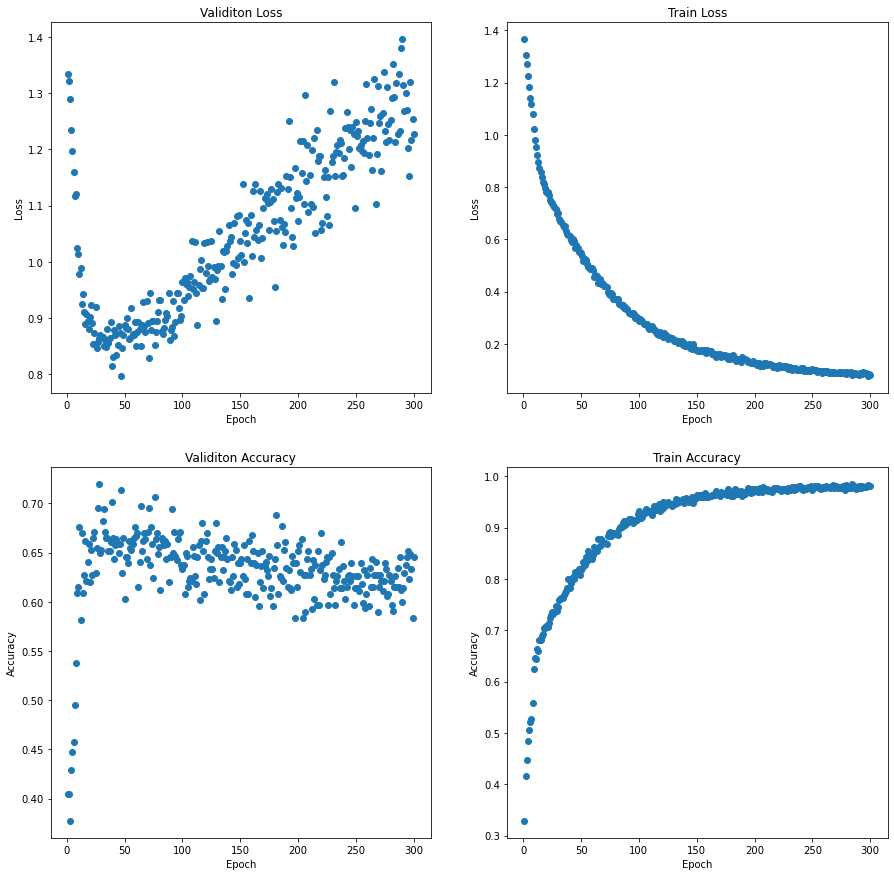

In [23]:

fig = plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.scatter(which_epoch,val_losses_avg)
plt.title("Validiton Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.subplot(2, 2, 2)
plt.scatter(which_epoch, t_losses_avg)
plt.title("Train Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.subplot(2, 2, 3)
plt.scatter(which_epoch, val_accuracies_avg)
plt.title("Validiton Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 4)
plt.scatter(which_epoch, t_accuracies_avg)
plt.title("Train Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()



       

### From the images above you can see how train loss continues to decrease while validation loss plateaus, and how train accuracy continues to increase while validation accuracy begins to plateau. This is why we’ve saved only the model sate with the highest accuracy that still has a lower validation loss than train loss.

##############################################################################################################################

# Deployment

### Model was deployed to Heroku using Flask: https://datascience-reddit-post-sorter.herokuapp.com/ . See my other files for the App file. 

############################################################################################################################

# Thank You!    --David Thorne, datadave@gmail.com